In [14]:
import collections
import itertools
import json
import os
import re
import glob
import operator

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]

In [15]:
def compute_accuracy(rows):
    levels = ['easy', 'medium', 'hard', 'extra', 'all']
    total = collections.defaultdict(int)
    exact = collections.defaultdict(int)
    for row in rows:
        exact[row['hardness']] += row['exact']
        exact['all'] += row['exact']
        total[row['hardness']] += 1
        total['all'] += 1
    
    result = {hardness: exact[hardness] / total[hardness]
              for hardness in levels}
    result = {**result, **{'{} count'.format(hardness): total[hardness] for hardness in levels}}
    return result

In [16]:
accuracy_per_run = collections.defaultdict(dict)
rows = []
for d in sorted(glob.glob('../logs/*')):
    exp_name = os.path.basename(d)
    if "wrong" in exp_name or "test" in exp_name:
        continue
    eval_paths = glob.glob(os.path.join(d, '*eval-val-step*-bs1.jsonl*'))
    all_scores = []
    best = (0, 0)
    for eval_path in eval_paths:
        if "ft" in eval_path and not eval_path.endswith("ft0"):
            continue
        step = int(re.search('step(\d+)', eval_path).group(1))
        scores = json.load(open(eval_path))
        first_half_exact = compute_accuracy(scores['per_item'][:517])
        second_half_exact = compute_accuracy(scores['per_item'][517:])
        all_scores.append((step, scores['total_scores']['all']['exact'], first_half_exact['all'], second_half_exact['all']))
    
    all_scores.sort(key=operator.itemgetter(0))
    sorted_scores = sorted(all_scores, reverse=True, key=operator.itemgetter(1))
    rows.append((exp_name,)+( len(eval_paths),) + (sorted_scores[0] if sorted_scores else (-1, -1, -1, -1)))
    accuracy_per_run[exp_name] = {
        'x': [s[0] for s in all_scores],
        'all': [s[1] for s in all_scores],
        '1/2': [s[2] for s in all_scores],
        '2/2': [s[3] for s in all_scores],
    }
    print(d)
    
df = pd.DataFrame(rows, columns=('name', 'num steps eval', 'step', 'acc', '1/2 acc', '2/2 acc'))
df

../logs/arxiv-1906.11790v1
../logs/meta-1014-maml-1e-3
../logs/meta-1014-nonmeta-1e-1
../logs/meta-1014-nonmeta-1e-2
../logs/meta-1014-nonmeta-1e-3
../logs/meta-1014-nonmeta-5e-3
../logs/meta-1014-reptile2-1e-3
../logs/meta-1014-reptile4-1e-2
../logs/meta-1014-reptile4-1e-3
../logs/meta-1014-reptile8-1e-3
../logs/meta-1020-maml-1e-2
../logs/meta-1020-reptile2-1e-2
../logs/meta-1024-maml-1e-2-ft32
../logs/meta-1024-nonmeta-1e-2-ft32
../logs/meta-1024-reptile2-1e-2-ft32
../logs/meta-1024-reptile4-1e-2-ft32
../logs/meta-1101-reptile8-1e-2-ft32
../logs/prev_best


,name,num steps eval,step,acc,1/2 acc,2/2 acc
0,arxiv-1906.11790v1,41,28100,0.411025,0.396518,0.425532
1,meta-1014-maml-1e-3,19,10000,0.368472,0.381044,0.355899
2,meta-1014-nonmeta-1e-1,8,10000,0.352031,0.355899,0.348162
3,meta-1014-nonmeta-1e-2,8,10000,0.352031,0.355899,0.348162
4,meta-1014-nonmeta-1e-3,18,10000,0.352031,0.355899,0.348162
5,meta-1014-nonmeta-5e-3,8,10000,0.352031,0.355899,0.348162
6,meta-1014-reptile2-1e-3,19,10000,0.384913,0.388781,0.381044
7,meta-1014-reptile4-1e-2,8,10000,0.387814,0.371373,0.404255
8,meta-1014-reptile4-1e-3,20,9100,0.397485,0.379110,0.415861
9,meta-1014-reptile8-1e-3,14,10000,0.394584,0.381044,0.408124


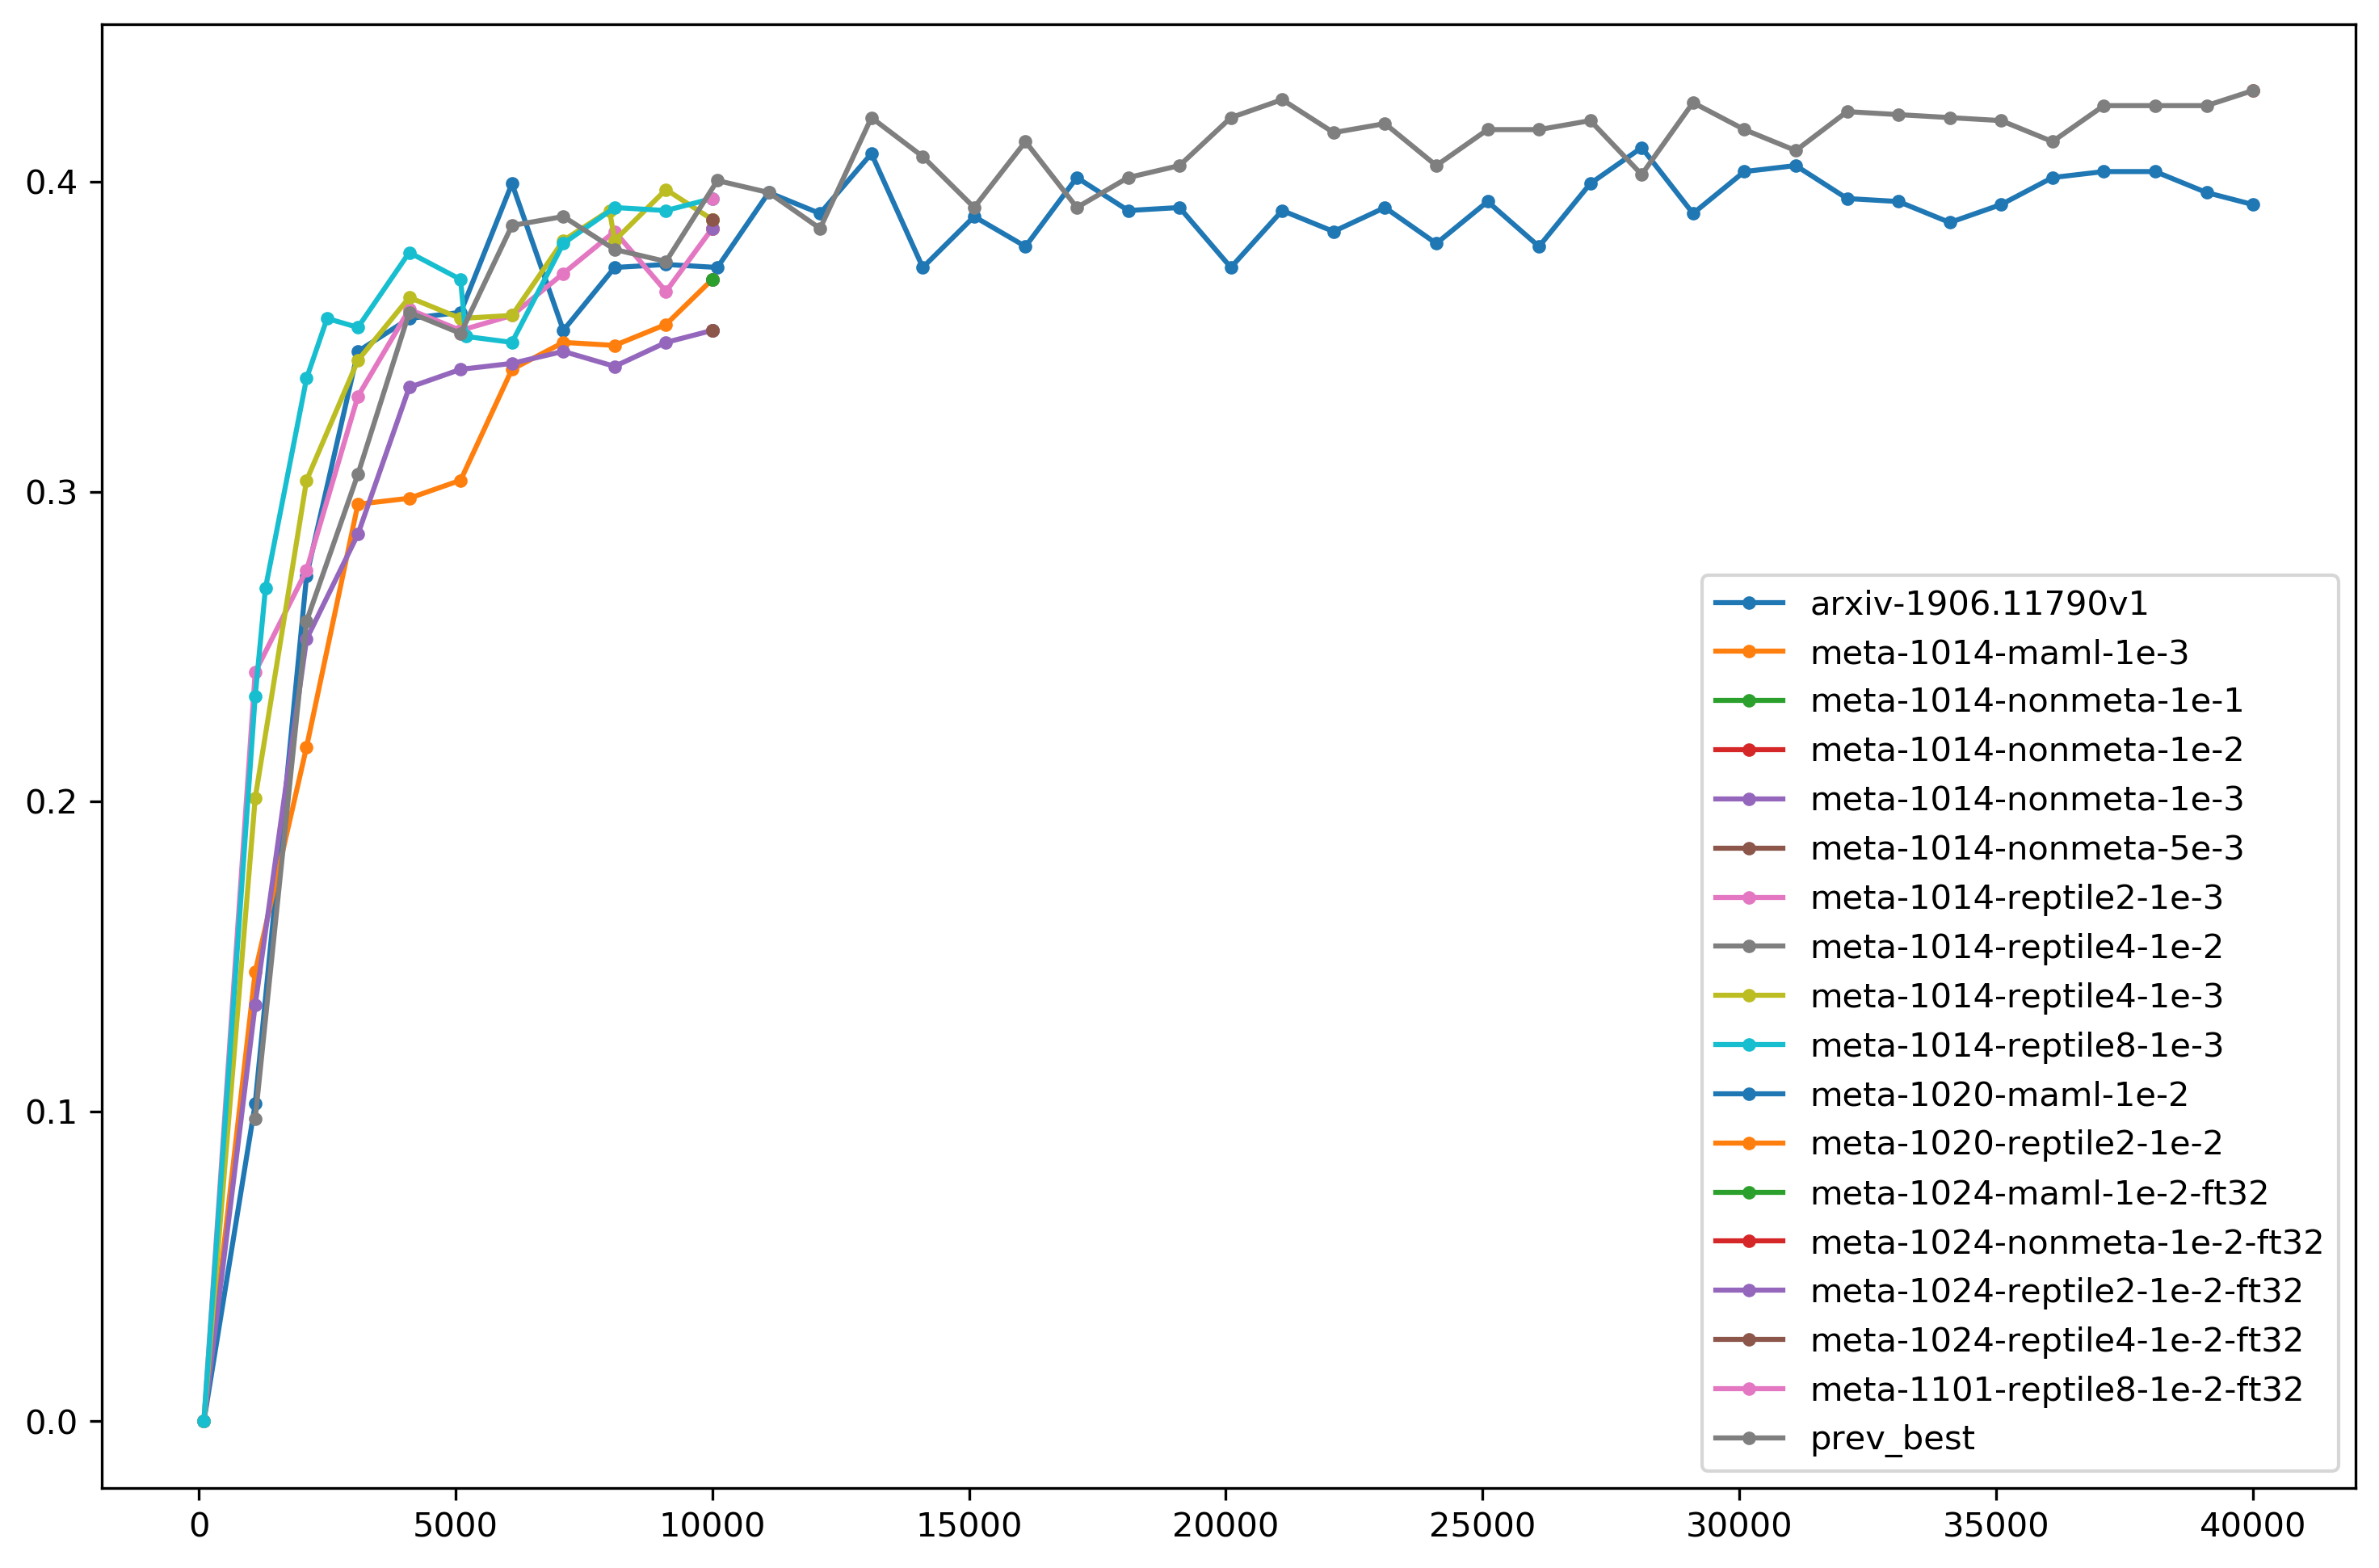

In [17]:
fig=plt.figure(figsize=(12, 8), dpi= 300, facecolor='w', edgecolor='k')
# See how accuracy varies over time
for k, v in sorted(accuracy_per_run.items()):
    plt.plot(v['x'], v['all'], marker='.', label=k)
plt.legend()


In [18]:
accuracy_per_run = collections.defaultdict(dict)
rows = []
for d in sorted(glob.glob('../logs/*')):
    if "1e-1" in d:
        continue
    exp_name = os.path.basename(d)
    if "wrong" in exp_name or "test" in exp_name:
        continue
    eval_paths = glob.glob(os.path.join(d, 'ft-eval-val-step*-bs1.jsonl*'))
    all_scores = []
    best = (0, 0)
    print(exp_name, d)
    for eval_path in eval_paths:
        # ft_num = int(re.search('ft(\d+)', eval_path).group(1))
        ft_num = int(eval_path.split("ft")[-1])
        scores = json.load(open(eval_path))
        first_half_exact = compute_accuracy(scores['per_item'][:517])
        second_half_exact = compute_accuracy(scores['per_item'][517:])
        # print(eval_path, scores['total_scores']['all']['exact'])
        all_scores.append((ft_num, scores['total_scores']['all']['exact'], first_half_exact['all'], second_half_exact['all']))
    
    all_scores.sort(key=operator.itemgetter(0))
    sorted_scores = sorted(all_scores, reverse=True, key=operator.itemgetter(1))
    rows.append((exp_name,)+( len(eval_paths),) + (sorted_scores[0] if sorted_scores else (-1, -1, -1, -1)))
    accuracy_per_run[exp_name] = {
        'x': [s[0] for s in all_scores],
        'all': [s[1] for s in all_scores],
        '1/2': [s[2] for s in all_scores],
        '2/2': [s[3] for s in all_scores],
    }
    
df = pd.DataFrame(rows, columns=('name', 'num steps eval', 'step', 'acc', '1/2 acc', '2/2 acc'))
df

arxiv-1906.11790v1 ../logs/arxiv-1906.11790v1
meta-1014-maml-1e-3 ../logs/meta-1014-maml-1e-3
meta-1014-nonmeta-1e-2 ../logs/meta-1014-nonmeta-1e-2
meta-1014-nonmeta-1e-3 ../logs/meta-1014-nonmeta-1e-3
meta-1014-nonmeta-5e-3 ../logs/meta-1014-nonmeta-5e-3
meta-1014-reptile2-1e-3 ../logs/meta-1014-reptile2-1e-3
meta-1014-reptile4-1e-2 ../logs/meta-1014-reptile4-1e-2
meta-1014-reptile4-1e-3 ../logs/meta-1014-reptile4-1e-3
meta-1014-reptile8-1e-3 ../logs/meta-1014-reptile8-1e-3
meta-1020-maml-1e-2 ../logs/meta-1020-maml-1e-2
meta-1020-reptile2-1e-2 ../logs/meta-1020-reptile2-1e-2
meta-1024-maml-1e-2-ft32 ../logs/meta-1024-maml-1e-2-ft32
meta-1024-nonmeta-1e-2-ft32 ../logs/meta-1024-nonmeta-1e-2-ft32
meta-1024-reptile2-1e-2-ft32 ../logs/meta-1024-reptile2-1e-2-ft32
meta-1024-reptile4-1e-2-ft32 ../logs/meta-1024-reptile4-1e-2-ft32
meta-1101-reptile8-1e-2-ft32 ../logs/meta-1101-reptile8-1e-2-ft32
prev_best ../logs/prev_best


,name,num steps eval,step,acc,1/2 acc,2/2 acc
0,arxiv-1906.11790v1,0,-1,-1.000000,-1.000000,-1.000000
1,meta-1014-maml-1e-3,8,6,0.393617,0.411992,0.375242
2,meta-1014-nonmeta-1e-2,8,6,0.423598,0.433269,0.413926
3,meta-1014-nonmeta-1e-3,8,7,0.400387,0.410058,0.390716
4,meta-1014-nonmeta-5e-3,8,6,0.412959,0.423598,0.402321
5,meta-1014-reptile2-1e-3,8,7,0.415861,0.444874,0.386847
6,meta-1014-reptile4-1e-2,8,7,0.458414,0.473888,0.442940
7,meta-1014-reptile4-1e-3,8,7,0.430368,0.435203,0.425532
8,meta-1014-reptile8-1e-3,0,-1,-1.000000,-1.000000,-1.000000
9,meta-1020-maml-1e-2,8,4,0.419729,0.427466,0.411992


[] []
[0, 1, 2, 3, 4, 5, 6, 7] [0.36847195357833656, 0.3665377176015474, 0.37620889748549324, 0.3849129593810445, 0.3858800773694391, 0.38878143133462284, 0.39361702127659576, 0.39361702127659576]
[0, 1, 2, 3, 4, 5, 6, 7] [0.3520309477756286, 0.39748549323017407, 0.41295938104448743, 0.4148936170212766, 0.4206963249516441, 0.4158607350096712, 0.42359767891682787, 0.42359767891682787]
[0, 1, 2, 3, 4, 5, 6, 7] [0.3520309477756286, 0.35589941972920697, 0.3713733075435203, 0.37620889748549324, 0.3829787234042553, 0.390715667311412, 0.39264990328820115, 0.40038684719535783]
[0, 1, 2, 3, 4, 5, 6, 7] [0.3520309477756286, 0.3897485493230174, 0.3994197292069632, 0.3994197292069632, 0.4119922630560928, 0.4081237911025145, 0.41295938104448743, 0.4119922630560928]
[0, 1, 2, 3, 4, 5, 6, 7] [0.3849129593810445, 0.3742746615087041, 0.3781431334622824, 0.3897485493230174, 0.3955512572533849, 0.3994197292069632, 0.4119922630560928, 0.4158607350096712]
[0, 1, 2, 3, 4, 5, 6, 7] [0.38781431334622823, 0.41

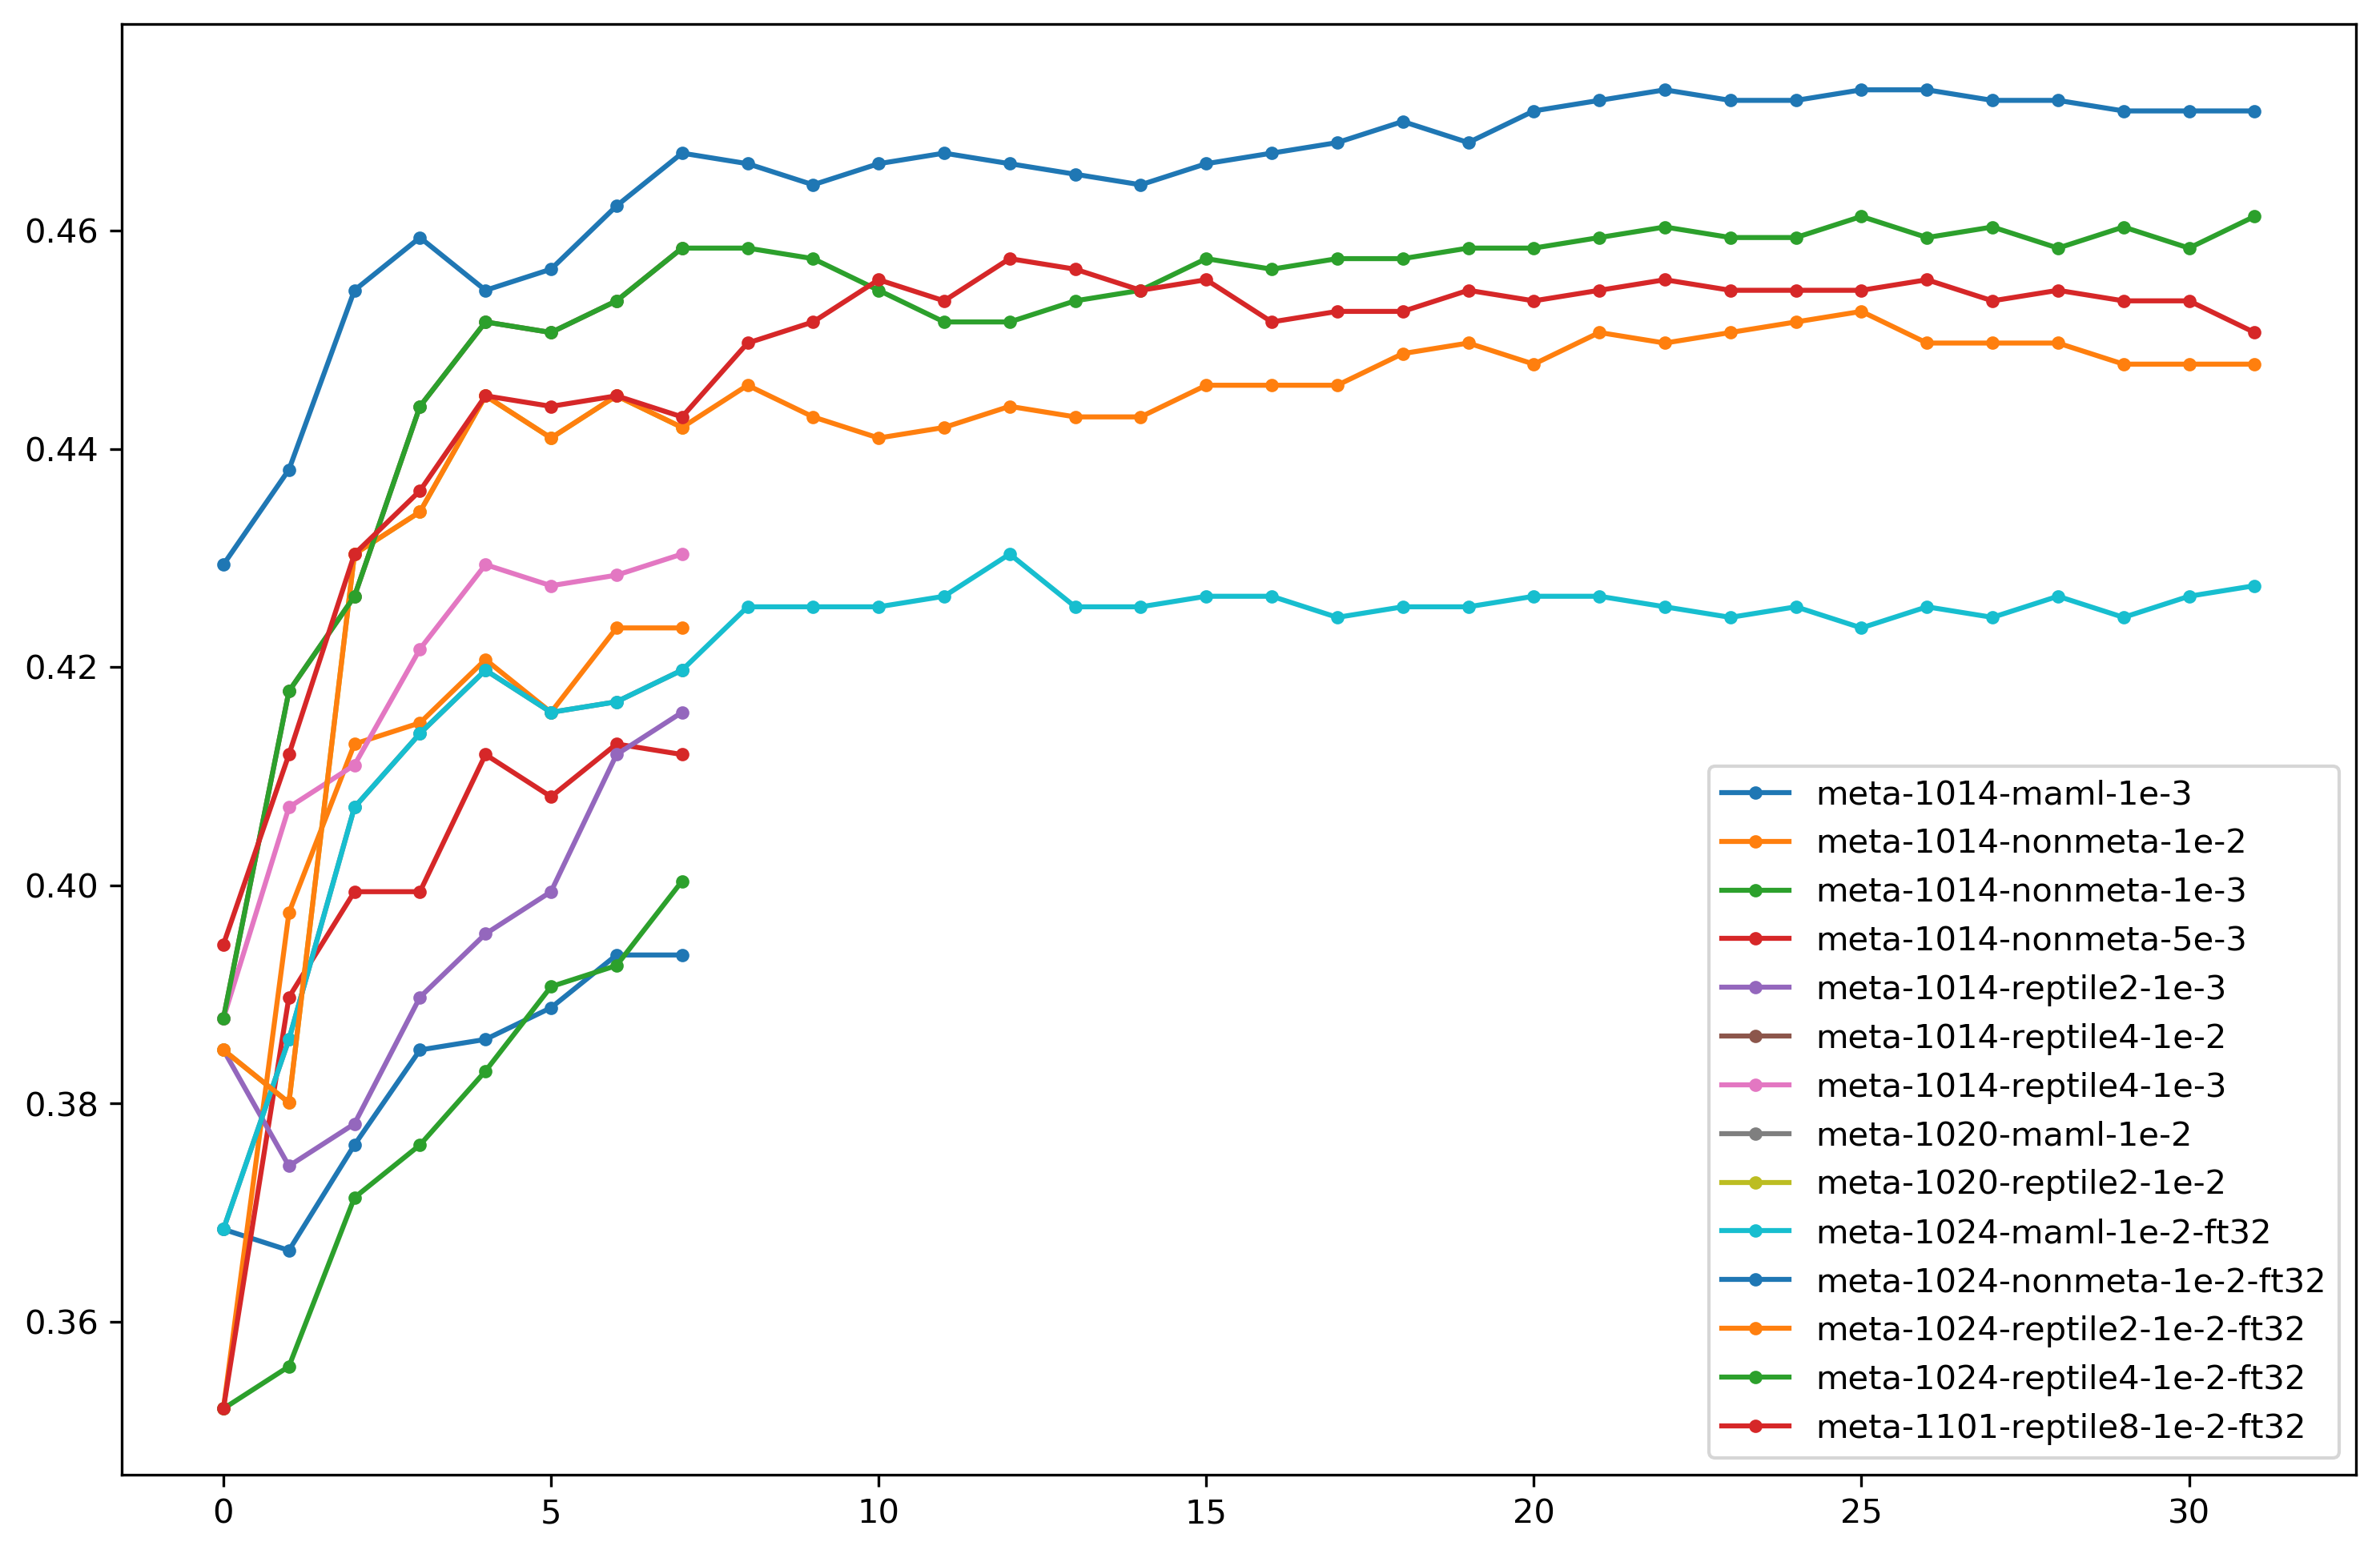

In [19]:
fig=plt.figure(figsize=(12, 8), dpi= 300, facecolor='w', edgecolor='k')
# See how accuracy varies over time
for k, v in sorted(accuracy_per_run.items()):
    print(v['x'], v['all'])
    if not v['x']:
        continue
    plt.plot(v['x'], v['all'], marker='.', label=k)
plt.legend()
